In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr  4 23:12:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/1512/Project_B_Supp')  # Change the directory to torchRay-master folder
# %reset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
!pip install keras-flops
from keras_flops import get_flops

     |████████████████████████████████| 462 kB 8.3 MB/s 


In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
from tensorflow.keras.utils import plot_model

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [ ]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten,Conv2D,MaxPooling2D,Dropout
import matplotlib.pyplot as plt

import numpy as np

%load_ext tensorboard
import datetime

In [ ]:
## @test {"output": "ignore"}

def build_teacher_model_fun(show_summary = 0):

    keras.backend.clear_session()
    # Build CNN teacher.
    cnn_model = tf.keras.Sequential(name='teacherNet')

    # your code start from here for stpe 2
    cnn_model.add(Conv2D(filters=32,kernel_size=3,activation='relu',strides=(1,1), padding = 'same', input_shape=(28,28,1)))

    cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1), padding = 'same'))

    cnn_model.add(Conv2D(filters=64,kernel_size=3,activation='relu',strides=(1,1), padding = 'same'))

    cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    # Flatten layer
    cnn_model.add(Flatten())

    cnn_model.add(Dropout(0.5))

    cnn_model.add(Dense(128, activation='relu'))

    cnn_model.add(Dropout(0.5))

    cnn_model.add(Dense(NUM_CLASSES, name='logits'))

    cnn_model.add(tf.keras.layers.Activation('softmax', name='softmax'))

    if(show_summary):
        cnn_model.summary()

    return cnn_model

cnn_model = build_teacher_model_fun(show_summary = 1)

Model: "teacherNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dropout (Dropout)           (None, 12544)             0

In [ ]:
# Build fully connected student.
def build_student_model_fun(show_summary = 0):

    keras.backend.clear_session()

    fc_model = tf.keras.Sequential(name='studentNet')

    # fc_model.add(MaxPooling2D(pool_size=(1,1),strides=(1,1),input_shape=(28,28,1)))

    # fc_model.add(MaxPooling2D(pool_size=(1,1),strides=(1,1)))

    # your code start from here for step 2
    fc_model.add(Flatten(input_shape=(28,28,1)))

    fc_model.add(Dense(784, activation='relu'))

    fc_model.add(Dense(784, activation='relu'))

    fc_model.add(Dense(NUM_CLASSES, name='logits'))

    fc_model.add(tf.keras.layers.Activation('softmax', name='softmax'))

    if(show_summary):
        fc_model.summary()

    return fc_model

fc_model = build_student_model_fun(show_summary = 1)

Model: "studentNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 784)               615440    
                                                                 
 logits (Dense)              (None, 10)                7850      
                                                                 
 softmax (Activation)        (None, 10)                0         
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


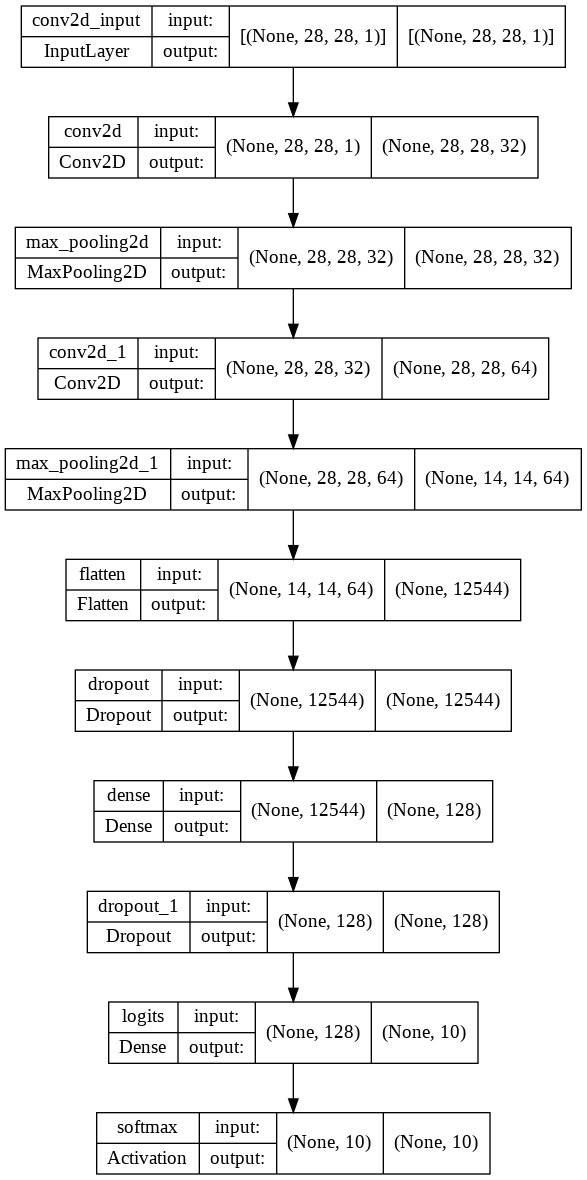

In [ ]:
plot_model(cnn_model, show_shapes=True)

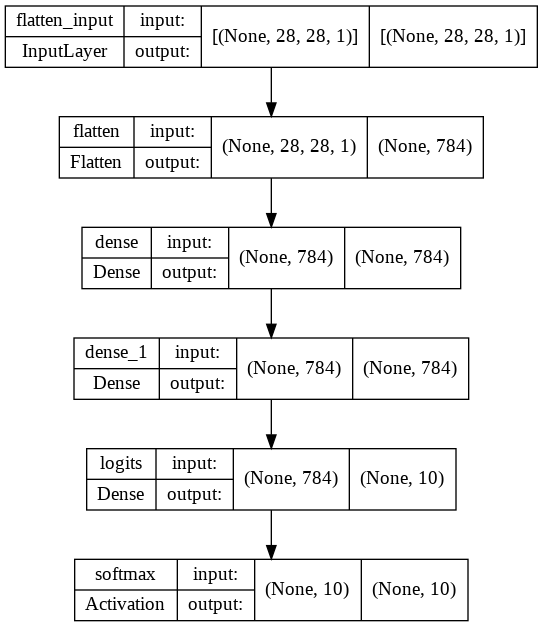

In [ ]:
plot_model(fc_model, show_shapes=True)

# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
    """Compute subclass knowledge distillation teacher loss for given images
        and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    subclass_logits = cnn_model(images, training=True)

    # Compute cross-entropy loss for subclasses.

    # your code start from here for step 3
    #   print(images)
    #   print(labels)
    #   one_hot_y = tf.one_hot([labels], 10)
    # one_hot_y = tf.one_hot(labels, 10)
    #   print("one_hot_y is:", one_hot_y)
    #   print("subclass_logits is:", subclass_logits)
    #   print("one_hot_y dim is:", one_hot_y.shape)

    #   diff = subclass_logits-one_hot_y
    y_pred = tf.clip_by_value(subclass_logits, 1e-7, 1 - 1e-7)
    cross_entropy_loss_value = -tf.math.reduce_mean(tf.math.reduce_sum(labels * tf.math.log(y_pred), axis=-1, keepdims=False))

    # cross_entropy_loss_value = 1/2 * (subclass_logits-one_hot_y)**2
    # cross_entropy_loss_value = tf.reduce_sum(cross_entropy_loss_value)

    # print("Current subclass_logits is:", subclass_logits)
    # print("Current labels is:", labels)
    # print("Current cross_entropy_loss_value is:", cross_entropy_loss_value)

    return cross_entropy_loss_value

# Student loss function

In [ ]:
def softmax_with_temp(logits, temp=1):
    logits = (logits - tf.math.reduce_max(logits)) / temp
    exp_logits = tf.math.exp(logits)
    logits_sum = tf.math.reduce_sum(exp_logits, axis=-1, keepdims=True)
    result = exp_logits / logits_sum
    return result

In [ ]:
# #@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    """Compute distillation loss.

    This function computes cross entropy between softened logits and softened
    targets. The resulting loss is scaled by the squared temperature so that
    the gradient magnitude remains approximately constant as the temperature is
    changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
    a neural network."

    Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
        shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

    Returns:
    A scalar Tensor containing the distillation loss.
    """
    # your code start from here for step 3
    soft_targets = teacher_logits/temperature

    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            soft_targets, student_logits / temperature)) * temperature ** 2

def distillation_loss2(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = softmax_with_temp(teacher_logits,temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def distillation_loss3(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = softmax_with_temp(teacher_logits,temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
    """Compute subclass knowledge distillation student loss for given images
        and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    student_subclass_logits_prob = fc_model(images, training=True)
    student_subclass_logits = fc_model_logits(images, training=True)

    # Compute subclass distillation loss between student subclass logits and
    # softened teacher subclass targets probabilities.

    # your code start from here for step 3

    teacher_subclass_logits_prob = cnn_model(images, training=False)
    teacher_subclass_logits = cnn_model_logits(images, training=False)

    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)
    distillation_loss_value2 = distillation_loss2(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    # Compute cross-entropy loss with hard targets.
    y_pred = tf.clip_by_value(student_subclass_logits_prob, 1e-7, 1 - 1e-7)
    origin_loss = -tf.math.reduce_mean(tf.math.reduce_sum(labels * tf.math.log(y_pred), axis=-1, keepdims=False))
    # your code start from here for step 3

    cross_entropy_loss_value = origin_loss + ALPHA*distillation_loss_value2
    # print("In case of formula 1")
    # weight_cal(origin_loss, ALPHA*distillation_loss_value)
    # print("In case of formula 2")
    # weight_cal(origin_loss, ALPHA*distillation_loss_value2)
    # print("\n")

    return cross_entropy_loss_value

def weight_cal(a,b):
    a = a.numpy()
    b = b.numpy()
    absa = abs(a)
    absb = abs(b)
    print("Origin loss is:", a)
    print("Knowledge distallitation loss is:", b)
    print("Origin loss take %s , and knowledge distallitation take %s weight." % (absa/(absa+absb), absb/(absa+absb)))
    print("And the total loss is:", a+b)
    
    return

In [ ]:
# print(distillation_loss(tf.convert_to_tensor([1.1,3.5,7.9]),tf.convert_to_tensor([1.1,3.5,7.9]),2.0))
# my_test_tensor1 = tf.convert_to_tensor([1.1,3.5,7.9])
# my_test_tensor2 = tf.convert_to_tensor([1.1,3.5,7.9])
# my_test_tensor3 = tf.convert_to_tensor([0.0,0.0,1.0])
# print(tf.nn.softmax_cross_entropy_with_logits(my_test_tensor3, my_test_tensor1))
# print(tf.nn.softmax_cross_entropy_with_logits(my_test_tensor1, my_test_tensor3))

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
    """Compute number of correctly classified images in a batch.

    Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Number of correctly classified images.
    """
    class_logits = model(images, training=False)
    return tf.reduce_sum(
        tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
                tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
    """Perform training and evaluation for a given model.

    Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    """

    # your code start from here for step 4
    my_learning_rate = 0.001
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)

    for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.

        print('Epoch {}: '.format(epoch), end='')

        for images, labels in mnist_train:
            with tf.GradientTape() as tape:
                # your code start from here for step 4

                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # optimizer.apply_gradients(zip(grads, fc_model_logits.trainable_variables))

        # Run evaluation.
        total_num_correct = 0
        num_total = builder.info.splits['test'].num_examples
        for images, labels in mnist_test:
            # your code start from here for step 4
            num_correct,_,_ = compute_num_correct(model, images, labels)
            total_num_correct = total_num_correct + num_correct
        print("Class_accuracy: " + '{:.2f}%'.format(
            total_num_correct / num_total * 100))
    return (total_num_correct / num_total * 100)


# Training models

In [ ]:
# your code start from here for step 5 
# build image banch
i=0
for images, labels in mnist_train:
    if (i==0):
        image_batch=images.numpy()
        label_batch=labels.numpy()
    else:
        image_batch=np.vstack([image_batch, images.numpy()])
        label_batch=np.vstack([label_batch, labels.numpy()])
    i = i+1

my_learning_rate = 0.001
my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()

log_dir="logs/fit/teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Your code 
cnn_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
history = cnn_model.fit(x = image_batch, y = label_batch, batch_size = BATCH_SIZE, epochs = 12, callbacks=[tensorboard_callback])
cnn_model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'-teacher.h5')

Epoch 1/12
234/234 [==============================] - 12s 12ms/step - loss: 0.2892 - accuracy: 0.9123
Epoch 2/12
234/234 [==============================] - 3s 11ms/step - loss: 0.1000 - accuracy: 0.9701
Epoch 3/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0762 - accuracy: 0.9773
Epoch 4/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0641 - accuracy: 0.9809
Epoch 5/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0564 - accuracy: 0.9826
Epoch 6/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0508 - accuracy: 0.9846
Epoch 7/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0443 - accuracy: 0.9862
Epoch 8/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0422 - accuracy: 0.9865
Epoch 9/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0370 - accuracy: 0.9883
Epoch 10/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0369 - accur

Correct digit: 2
Predicted digit: 2
Confidence score for the correct label: 1.0


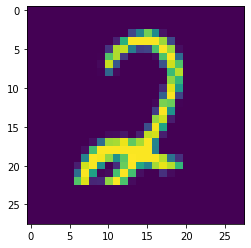

In [ ]:
# test teacher model
index = int(np.floor(np.random.rand()*1000))
input = image_batch[index]
one_hot_label = label_batch[index]
label = np.argmax(label_batch[index])
plt.imshow(input[:,:,0])
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(cnn_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(cnn_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy()[0,label]))

In [ ]:
fc_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
cnn_model_logits = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('logits').output)
fc_model_logits = tf.keras.Model(inputs=fc_model.input, outputs=fc_model.get_layer('logits').output)
cnn_model_logits.summary()
fc_model_logits.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0     

Correct digit: 1
Predicted digit: 6
Confidence score for the correct label: 0.06598804
model output is:  [[0.08864463 0.06598804 0.08023911 0.10329702 0.11501493 0.08836235
  0.12801272 0.11761893 0.11790182 0.09492051]]
logits model output is:  [[-0.05980741 -0.35496935 -0.15943186  0.09316551  0.200619   -0.06299708
   0.3076867   0.22300705  0.22540933  0.00859687]]


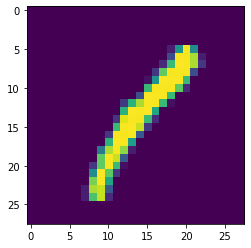

In [ ]:
# test student model
# index = int(np.floor(np.random.rand()*1000))
index = 56
input = image_batch[index]
one_hot_label = label_batch[index]
label = np.argmax(label_batch[index])
plt.imshow(input[:,:,0])
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(fc_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(fc_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy()[0,label]))

print("model output is: ", fc_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())
print("logits model output is: ", fc_model_logits(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())

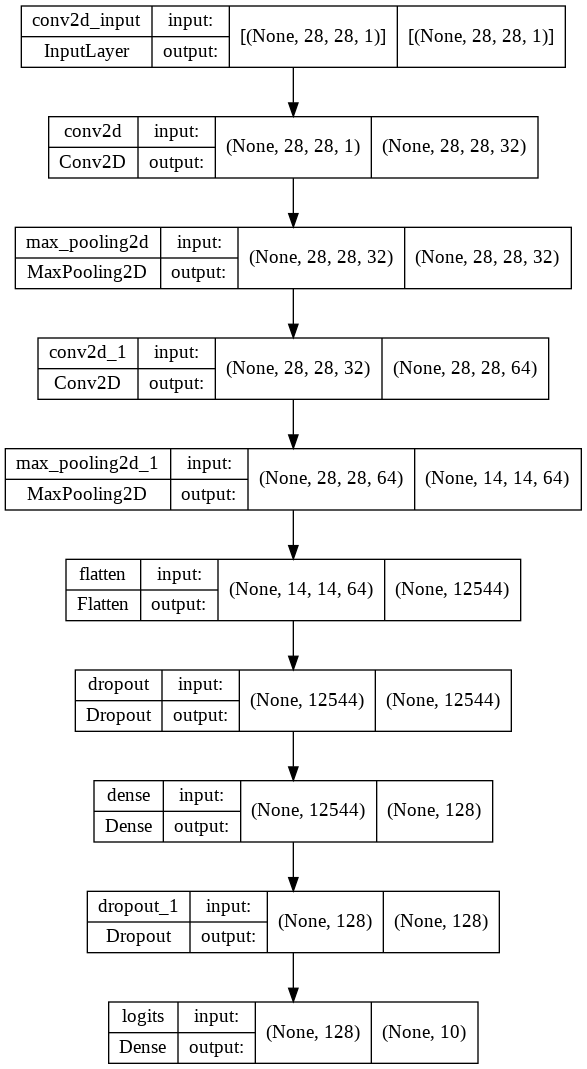

In [ ]:
plot_model(cnn_model_logits, show_shapes=True)

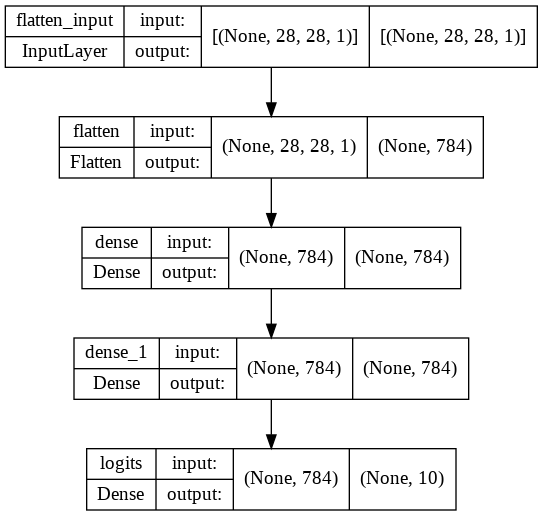

In [ ]:
plot_model(fc_model_logits, show_shapes=True)

In [ ]:
# your code start from here for step 5 
acc = train_and_evaluate(fc_model, compute_student_loss)
print(acc.numpy())

Epoch 1: Class_accuracy: 98.00%
Epoch 2: Class_accuracy: 98.30%
Epoch 3: Class_accuracy: 98.42%
Epoch 4: Class_accuracy: 98.57%
Epoch 5: Class_accuracy: 98.70%
Epoch 6: Class_accuracy: 98.68%
Epoch 7: Class_accuracy: 98.58%
Epoch 8: Class_accuracy: 98.67%
Epoch 9: Class_accuracy: 98.67%
Epoch 10: Class_accuracy: 98.68%
Epoch 11: Class_accuracy: 98.57%
Epoch 12: Class_accuracy: 98.71%
98.71


# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
temperature_array = [1.,2.,4.,8.,16.,32.,64.]
class_accuracy_array = []
for t in temperature_array:
    DISTILLATION_TEMPERATURE = t
    fc_model = build_student_model_fun()
    fc_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
    fc_model_logits = tf.keras.Model(inputs=fc_model.input, outputs=fc_model.get_layer('logits').output)
    acc = train_and_evaluate(fc_model, compute_student_loss)
    print("In temperature = %s, accuracy after 12 epoch is: %s." %(t,acc.numpy()))
    class_accuracy_array.append(acc)


Epoch 1: Class_accuracy: 96.88%
Epoch 2: Class_accuracy: 97.49%
Epoch 3: Class_accuracy: 97.89%
Epoch 4: Class_accuracy: 97.98%
Epoch 5: Class_accuracy: 97.73%
Epoch 6: Class_accuracy: 98.52%
Epoch 7: Class_accuracy: 98.15%
Epoch 8: Class_accuracy: 97.89%
Epoch 9: Class_accuracy: 98.35%
Epoch 10: Class_accuracy: 98.41%
Epoch 11: Class_accuracy: 98.06%
Epoch 12: Class_accuracy: 98.16%
In temperature = 1.0, accuracy after 12 epoch is: 98.159996.
Epoch 1: Class_accuracy: 96.42%
Epoch 2: Class_accuracy: 97.46%
Epoch 3: Class_accuracy: 97.72%
Epoch 4: Class_accuracy: 98.15%
Epoch 5: Class_accuracy: 98.24%
Epoch 6: Class_accuracy: 98.48%
Epoch 7: Class_accuracy: 98.31%
Epoch 8: Class_accuracy: 98.55%
Epoch 9: Class_accuracy: 98.60%
Epoch 10: Class_accuracy: 98.63%
Epoch 11: Class_accuracy: 98.67%
Epoch 12: Class_accuracy: 98.41%
In temperature = 2.0, accuracy after 12 epoch is: 98.409996.
Epoch 1: Class_accuracy: 96.51%
Epoch 2: Class_accuracy: 97.77%
Epoch 3: Class_accuracy: 98.06%
Epoch 4:

[98.159996 98.409996 98.71     98.77     98.83     98.799995 98.92    ]


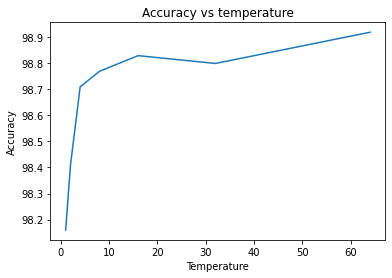

In [ ]:
class_accuracy_array_np = np.array(class_accuracy_array)
print(class_accuracy_array_np)
plt.plot(temperature_array, class_accuracy_array_np)
plt.title("Accuracy vs temperature")
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.show()

# Train student from scratch

In [ ]:
# Build fully connected student.
# your code start from here for step 7
fc_model_no_distillation = build_student_model_fun()

## @test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
    """Compute plain loss for given images and labels.

    For fair comparison and convenience, this function also performs a
    LogSumExp over subclasses, but does not perform subclass distillation.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    # your code start from here for step 7

    student_subclass_logits_prob = fc_model_no_distillation(images, training=True)

    # Compute cross-entropy loss with hard targets.
    y_pred = tf.clip_by_value(student_subclass_logits_prob, 1e-7, 1 - 1e-7)
    origin_loss = -tf.math.reduce_mean(tf.math.reduce_sum(labels * tf.math.log(y_pred), axis=-1, keepdims=False))
    # your code start from here for step 3

    cross_entropy_loss_value = origin_loss

    return cross_entropy_loss_value

acc = train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)
print(acc.numpy())

Epoch 1: Class_accuracy: 96.10%
Epoch 2: Class_accuracy: 97.64%
Epoch 3: Class_accuracy: 97.78%
Epoch 4: Class_accuracy: 97.84%
Epoch 5: Class_accuracy: 98.02%
Epoch 6: Class_accuracy: 97.75%
Epoch 7: Class_accuracy: 98.06%
Epoch 8: Class_accuracy: 98.11%
Epoch 9: Class_accuracy: 98.05%
Epoch 10: Class_accuracy: 97.87%
Epoch 11: Class_accuracy: 98.10%
Epoch 12: Class_accuracy: 98.21%
98.21


# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
# your code start from here for step 8
print("For teacher model:")
flops = get_flops(cnn_model, batch_size = 1)
print(f"FLOPS: {flops / 10 ** 9:.03}G")
print("For student model:")
flops = get_flops(fc_model, batch_size = 1)
print(f"FLOPS: {flops / 10 ** 9:.03}G")
print("For student model without distillation:")
flops = get_flops(fc_model_no_distillation, batch_size = 1)
print(f"FLOPS: {flops / 10 ** 9:.03}G")

For teacher model:
FLOPS: 0.0328G
For student model:
FLOPS: 0.00248G
For student model without distillation:
FLOPS: 0.00248G


# XAI method to explain models

In [ ]:
# your code start from here for step 9
%load_ext autoreload
%autoreload 2
from xai_utils import *


True label:  3
Teacher predicted_label:  3
Teacher confidence score for the correct label: 0.9999994
Student predicted_label:  3
Student confidence score for the correct label: 0.9999989
Student no distillation predicted_label:  3
Student no distillation confidence score for the correct label: 0.9999968


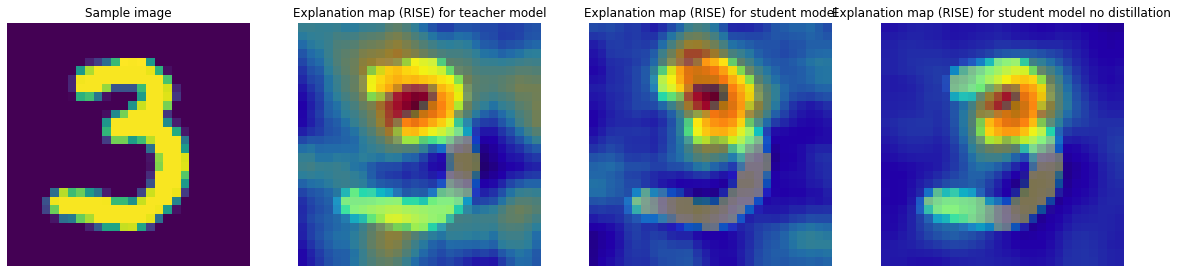

In [ ]:
def my_XAI_test(image_batch, label_batch, index, model1 = cnn_model, model2 = fc_model, model3 = fc_model_no_distillation):

    prediction=model1(image_batch)
    prediction_2=model2(image_batch)
    prediction_3=model3(image_batch)
    print('True label: ',np.argmax(label_batch[index]))
    print('Teacher predicted_label: ',np.argmax(prediction[index]))
    print('Teacher confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
    print('Student predicted_label: ',np.argmax(prediction_2[index]))
    print('Student confidence score for the correct label: '+str(prediction_2[index][np.argmax(label_batch[index])].numpy()))
    print('Student no distillation predicted_label: ',np.argmax(prediction_3[index]))
    print('Student no distillation confidence score for the correct label: '+str(prediction_3[index][np.argmax(label_batch[index])].numpy()))

    explanation_map_RISE = RISE(image_batch[index], model1, class_index=np.argmax(prediction[index]) ,N_MASKS=8000, H = 28, W = 28, C = 1)
    explanation_map_RISE -= explanation_map_RISE.min()
    explanation_map_RISE /= explanation_map_RISE.max()+10e-30

    explanation_map_RISE_2 = RISE(image_batch[index], model2, class_index=np.argmax(prediction[index]) ,N_MASKS=8000, H = 28, W = 28, C = 1)
    explanation_map_RISE_2 -= explanation_map_RISE_2.min()
    explanation_map_RISE_2 /= explanation_map_RISE_2.max()+10e-30

    explanation_map_RISE_3 = RISE(image_batch[index], model3, class_index=np.argmax(prediction[index]) ,N_MASKS=8000, H = 28, W = 28, C = 1)
    explanation_map_RISE_3 -= explanation_map_RISE_3.min()
    explanation_map_RISE_3 /= explanation_map_RISE_3.max()+10e-30

    plt.figure(figsize=(20,5))

    plt.subplot(1,4,1)
    plt.imshow(image_batch[index,:,:,0])
    plt.axis('off')
    plt.title('Sample image')

    plt.subplot(1,4,2)
    plt.imshow(image_batch[index,:,:,0])
    plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (RISE) for teacher model')

    plt.subplot(1,4,3)
    plt.imshow(image_batch[index,:,:,0])
    plt.imshow(explanation_map_RISE_2, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (RISE) for student model')

    plt.subplot(1,4,4)
    plt.imshow(image_batch[index,:,:,0])
    plt.imshow(explanation_map_RISE_3, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (RISE) for student model no distillation')

my_XAI_test(image_batch[0:256,:,:,:], label_batch[0:256,:], 8)

True label:  1
Teacher predicted_label:  1
Teacher confidence score for the correct label: 0.9999993
Student predicted_label:  1
Student confidence score for the correct label: 0.9999994
Student no distillation predicted_label:  1
Student no distillation confidence score for the correct label: 1.0
True label:  3
Teacher predicted_label:  3
Teacher confidence score for the correct label: 1.0
Student predicted_label:  3
Student confidence score for the correct label: 1.0
Student no distillation predicted_label:  3
Student no distillation confidence score for the correct label: 1.0
True label:  5
Teacher predicted_label:  5
Teacher confidence score for the correct label: 1.0
Student predicted_label:  5
Student confidence score for the correct label: 1.0
Student no distillation predicted_label:  5
Student no distillation confidence score for the correct label: 1.0
True label:  3
Teacher predicted_label:  3
Teacher confidence score for the correct label: 1.0
Student predicted_label:  3
Stud

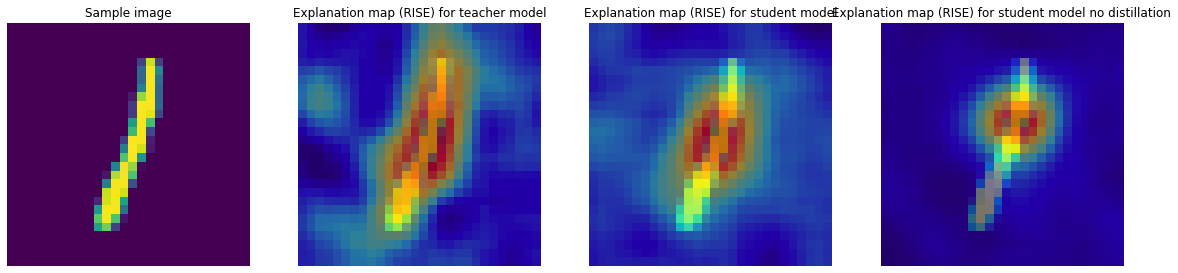

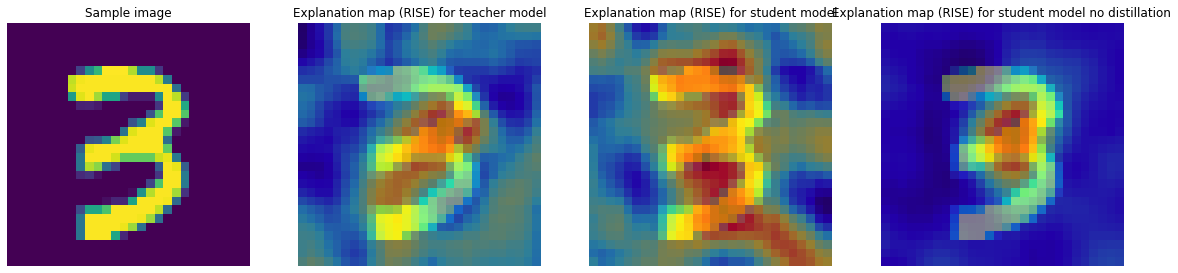

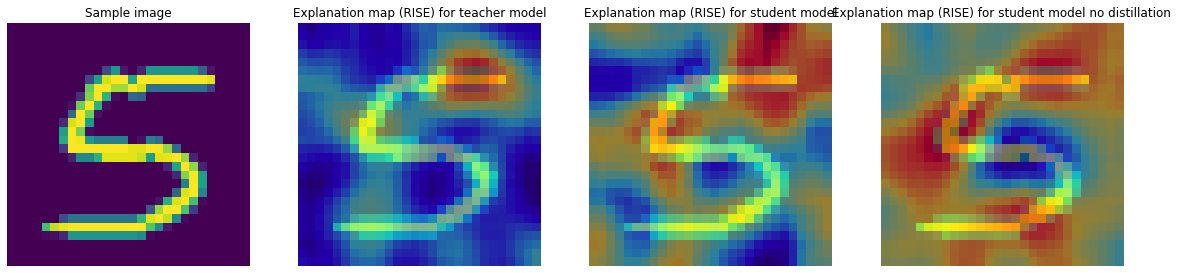

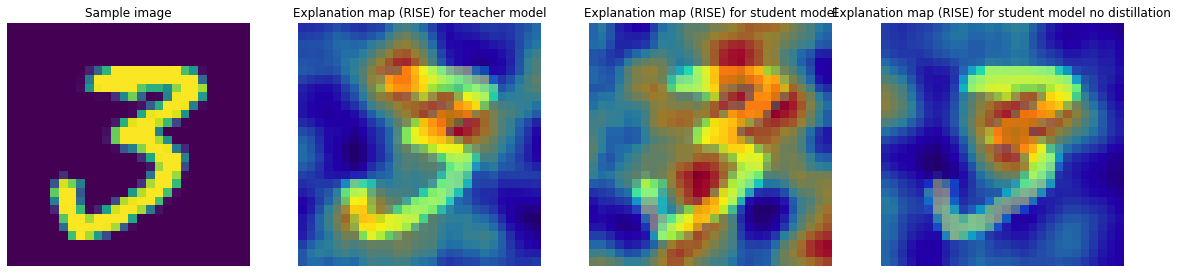

In [ ]:
my_XAI_test(image_batch[0:256,:,:,:], label_batch[0:256,:], 9)
my_XAI_test(image_batch[0:256,:,:,:], label_batch[0:256,:], 10)
my_XAI_test(image_batch[0:256,:,:,:], label_batch[0:256,:], 11)
my_XAI_test(image_batch[0:256,:,:,:], label_batch[0:256,:], 12)

True label:  6
Teacher predicted_label:  6
Teacher confidence score for the correct label: 0.9999988
Student predicted_label:  6
Student confidence score for the correct label: 0.9999994
Student no distillation predicted_label:  6
Student no distillation confidence score for the correct label: 1.0
True label:  5
Teacher predicted_label:  5
Teacher confidence score for the correct label: 0.9999926
Student predicted_label:  5
Student confidence score for the correct label: 0.99998724
Student no distillation predicted_label:  5
Student no distillation confidence score for the correct label: 0.99999964
True label:  9
Teacher predicted_label:  9
Teacher confidence score for the correct label: 0.99997675
Student predicted_label:  9
Student confidence score for the correct label: 0.9998512
Student no distillation predicted_label:  9
Student no distillation confidence score for the correct label: 0.9999995
True label:  5
Teacher predicted_label:  5
Teacher confidence score for the correct labe

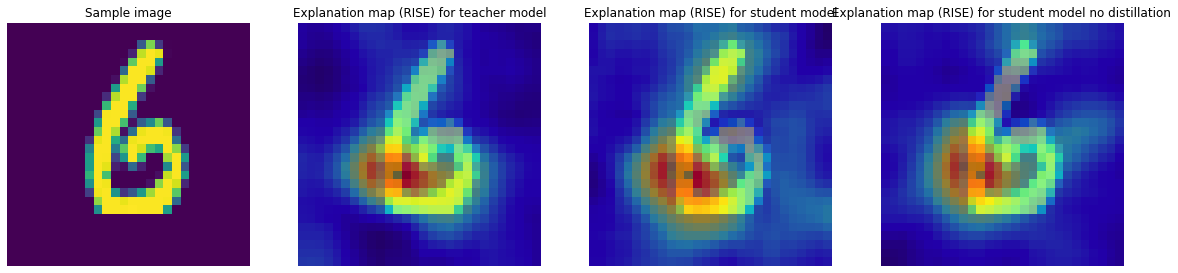

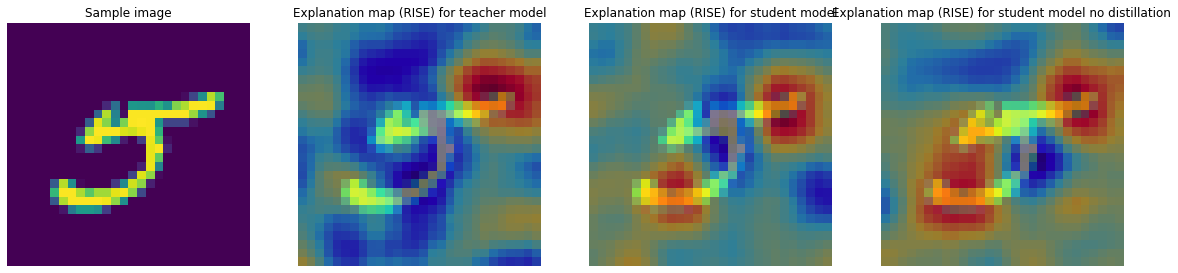

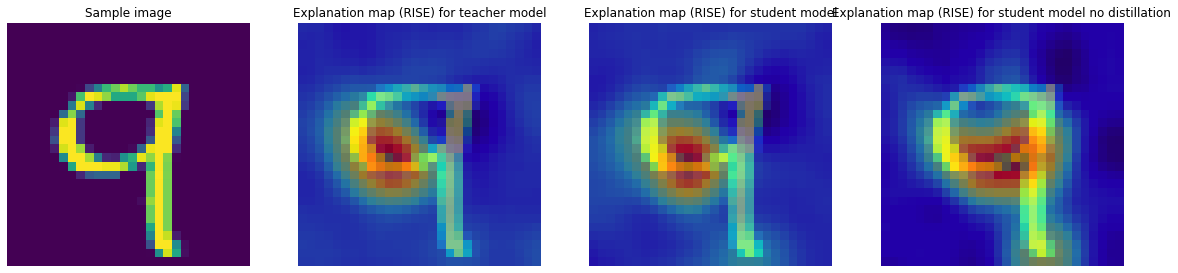

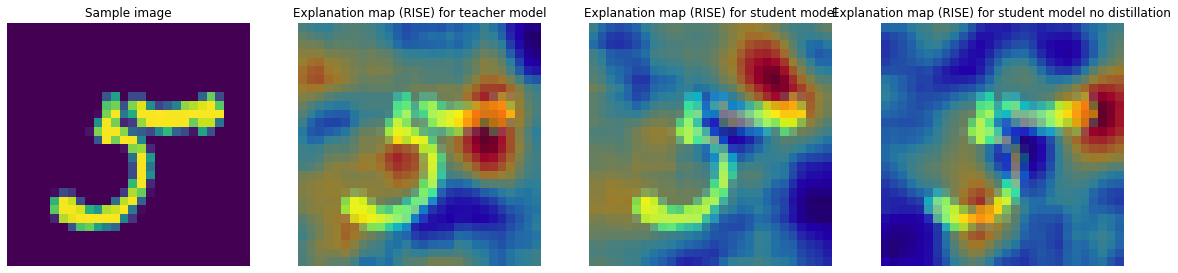

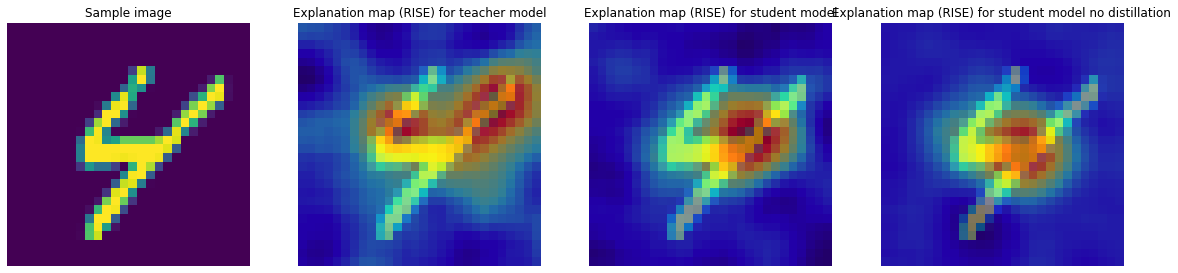

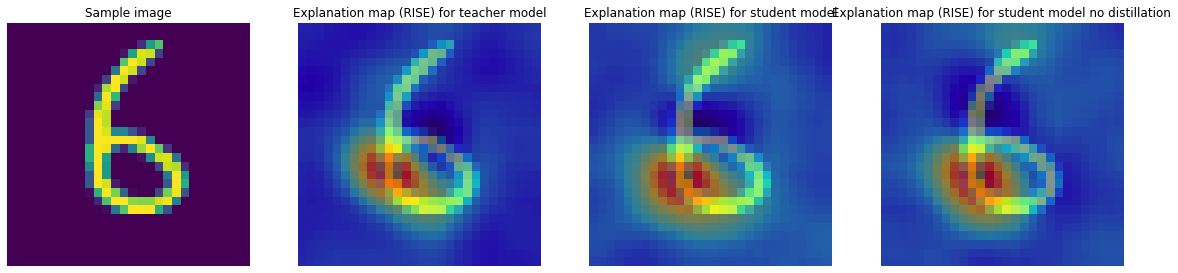

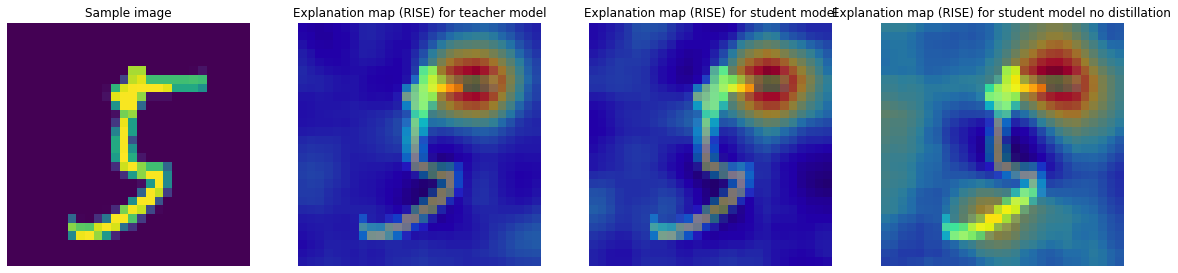

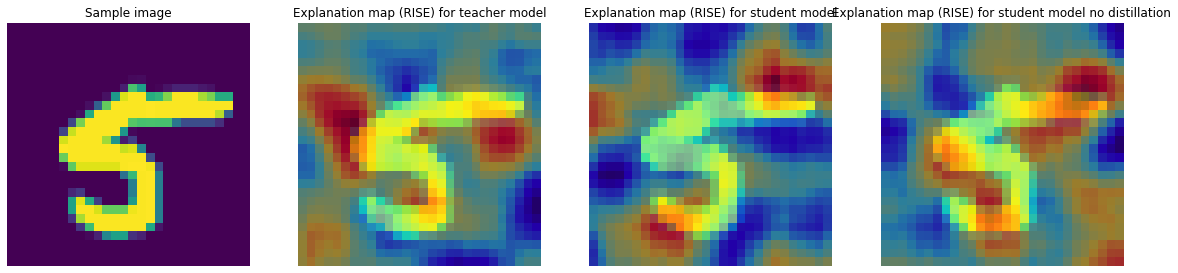

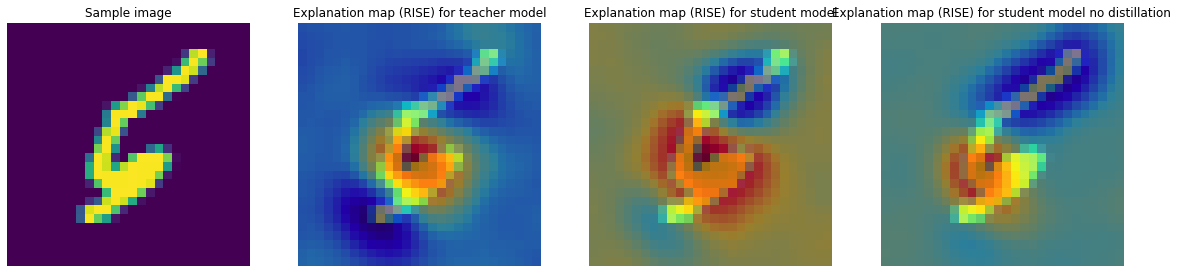

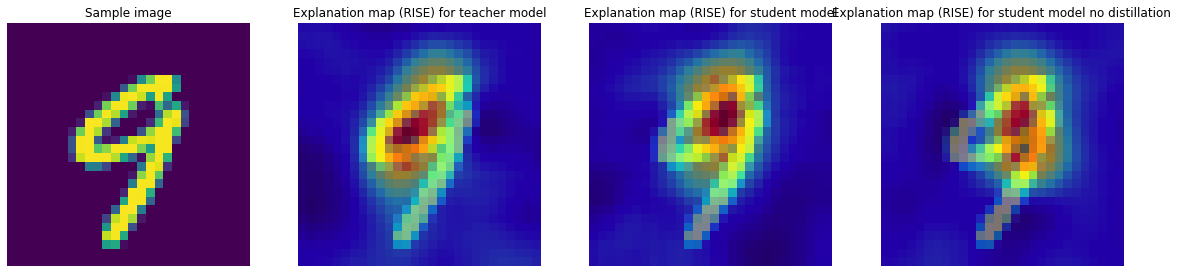

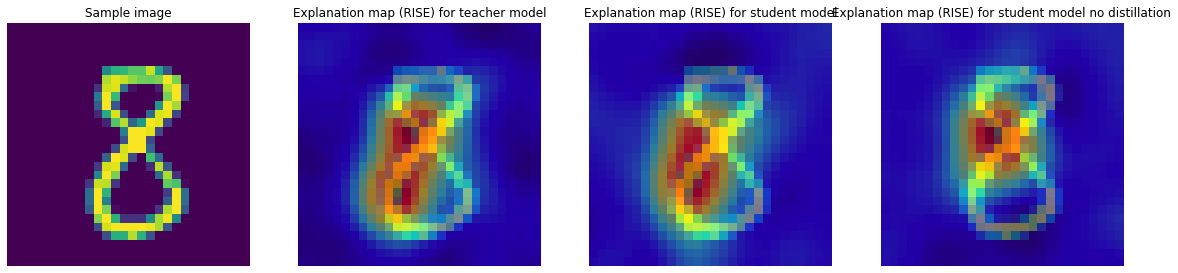

In [ ]:
for i in range (30,41):
    my_XAI_test(image_batch[0:256,:,:,:], label_batch[0:256,:], i)

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 13
epoch_array = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
transfer_teacher_model_array = []
transfer_student_model_array = []

my_learning_rate = 0.001
my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()
log_dir="logs/fit/teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

for epoch_num in epoch_array:
    # log_dir2="logs/fit/HMT_teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)
    cnn_model = build_teacher_model_fun()
    cnn_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
    fc_model = build_student_model_fun()
    fc_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
    cnn_model_logits = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('logits').output)
    fc_model_logits = tf.keras.Model(inputs=fc_model.input, outputs=fc_model.get_layer('logits').output)

    history = cnn_model.fit(x = image_batch, y = label_batch, batch_size = BATCH_SIZE, epochs = epoch_num, callbacks=[tensorboard_callback])
    train_and_evaluate(fc_model, compute_student_loss)

    # test_acc = evaluate_accuracy(hmt_transfer_teacher_model, np_test_set, np_test_label)
    # hmt_transfer_teacher_model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ '-epoch-'+str(epoch_num)+'-acc-'+str('{:.2f}'.format(test_acc)) +'-HMTteacher')
    print('In case of train teacher with %s epoch' % epoch_num)
    transfer_teacher_model_array.append(cnn_model)
    transfer_student_model_array.append(fc_model)

234/234 [==============================] - 3s 11ms/step - loss: 0.2915 - accuracy: 0.9084
Epoch 1: Class_accuracy: 97.14%
Epoch 2: Class_accuracy: 97.75%
Epoch 3: Class_accuracy: 98.25%
Epoch 4: Class_accuracy: 98.28%
Epoch 5: Class_accuracy: 98.32%
Epoch 6: Class_accuracy: 98.32%
Epoch 7: Class_accuracy: 98.43%
Epoch 8: Class_accuracy: 98.47%
Epoch 9: Class_accuracy: 98.48%
Epoch 10: Class_accuracy: 98.55%
Epoch 11: Class_accuracy: 98.53%
Epoch 12: Class_accuracy: 98.51%
In case of train teacher with 1 epoch
Epoch 1/2
234/234 [==============================] - 3s 11ms/step - loss: 0.2295 - accuracy: 0.9280
Epoch 2/2
234/234 [==============================] - 3s 11ms/step - loss: 0.0856 - accuracy: 0.9747
Epoch 1: Class_accuracy: 97.21%
Epoch 2: Class_accuracy: 98.01%
Epoch 3: Class_accuracy: 98.40%
Epoch 4: Class_accuracy: 98.47%
Epoch 5: Class_accuracy: 98.63%
Epoch 6: Class_accuracy: 98.54%
Epoch 7: Class_accuracy: 98.63%
Epoch 8: Class_accuracy: 98.70%
Epoch 9: Class_accuracy: 98.7

In [ ]:
teacher_model_acc_array = []
student_model_acc_array = []
for cnn_model in transfer_teacher_model_array:
    total_num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
        # your code start from here for step 4
        num_correct,_,_ = compute_num_correct(cnn_model, images, labels)
        total_num_correct = total_num_correct + num_correct
    acc = total_num_correct / num_total * 100
    teacher_model_acc_array.append(acc)

for fc_model in transfer_student_model_array:
    total_num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
        # your code start from here for step 4
        num_correct,_,_ = compute_num_correct(cnn_model, images, labels)
        total_num_correct = total_num_correct + num_correct
    acc = total_num_correct / num_total * 100
    student_model_acc_array.append(acc)

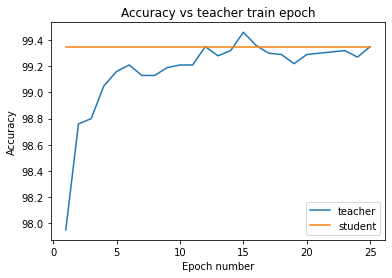

In [ ]:
plt.plot(epoch_array, teacher_model_acc_array, label = 'teacher')
plt.plot(epoch_array, student_model_acc_array, label = 'student')
plt.legend()
plt.title("Accuracy vs teacher train epoch")
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()